In [79]:
import os
import time
import pandas as pd
from argparse import ArgumentParser
from datetime import datetime
import datetime as dt
from gbportfolio.tools.utils import create_timespan
import gbportfolio.tools.configprocess as conf
import logging
import json
import matplotlib.pyplot as plt

In [2]:
def build_parser():
    parser = ArgumentParser()
    parser.add_argument("--mode",dest="mode",
                        help="download_data",
                        metavar="MODE", default="train")
    parser.add_argument("--processes", dest="processes",
                        help="number of processes you want to start to train the network",
                        default="1")
    parser.add_argument("--device", dest="device", default="cpu",
                        help="device to be used to train")
    parser.add_argument("--folder", dest="folder", type=int,
                        help="folder(int) to load the config, neglect this option if loading from ./pgportfolio/net_config")
    return parser

In [3]:
def main_test(timespan):
    mode = "prepare_data"
    #parser = build_parser()
    #options = parser.parse_args()    
    #For logging issues:
    from gbportfolio.data.data import GlobalData
    from gbportfolio.data.data import CoinsDataframe
    logging.basicConfig(filename='make_graph.log',level=logging.DEBUG)
    with open("./gbportfolio/config.json") as file:
        config = json.load(file)
    start, end = create_timespan(timespan)
    print(start, end)
    coinlist = config["input"]["coin_list"]
    print(coinlist)
    base_currency = config["input"]["base_currency"]
    period = config["input"]["period"]
    db_path = os.path.join("./" + "database", base_currency + ".db")
    logging.info("Getting data from %i to %i. Coinlist: %s. Base currency: %s. Period %i"%(start, end, coinlist, base_currency, period))
    data = GlobalData(db_path, start, end, base_currency, coinlist)
    #add data to certain coins if missing
    data.update_all_coins()
    # Prepare pandas dataframe for learning
    gdf = CoinsDataframe(data.extract_pandas_dataframe(coinlist=coinlist), start, end, period)

    # Prepare pandas dataframe for learning
    gdf = CoinsDataframe(data.extract_pandas_dataframe(coinlist=coinlist), start, end, period)
    return gdf

In [4]:
class CoinsDataframe:
    def __init__(self, df, start, end, period):
        self.df = df
        self.start = start
        self.end = end
        self.period = period
        self.coin_counts = self._get_unique_coin_records()
        
    def get_df(self):
        return self.df
        
    def get_coin_counts(self):
        return self.coin_counts
        
    def _get_unique_coin_records(self):
        '''
        returns the count of records for each coin in the database (if it is the same).
        logs if there is a value with different count
        '''
        coin_counts = self.df.groupby('coin')['date'].nunique()
        count = 0
        for i in range(len(coin_counts)):
            if count == 0:
                count = coin_counts[i]
            else:
                if count != coin_counts[i]:
                    logging.debug("Coins have different counts")
                    return coin_counts
        return coin_counts

In [20]:
df = main_test("3D").get_df()
print(df.tail())
df =df.set_index(['coin', 'date'])
#convert index to datetime
df.index = df.index.set_levels([df.index.levels[0], pd.to_datetime(df.index.levels[1], unit='s')])
df = df.sort_index()
coinlist = list(set(df.index.get_level_values(0)))
#print("g", coinlist)
#get the time of last open price for each index
last_open_times = {c : df.loc[c].index.max() for c in coinlist}
last_open_prices = {c : df.loc[(c, last_open_times[c])]['open'] for c in coinlist}
first_open_times = {c : df.loc[c].index.min() for c in coinlist}
first_open_prices = {c : df.loc[(c, first_open_times[c])]['open'] for c in coinlist}
first_volume = {c : df.loc[(c, first_open_times[c])]['volume'] for c in coinlist}
#print(last_prices)
#df.loc['XRP']['open']
#df.tail(30)

1547998934.2058227 1548258134.2058227
['BTC', 'ETH', 'LTC', 'XRP', 'ZEC']
           date coin         high          low         open        close  \
712  1548255600  LTC    31.508815    31.508815    31.508815    31.508815   
713  1548255600  XRP     0.317177     0.316376     0.316376     0.317177   
714  1548257400  BTC  3568.000000  3568.000000  3568.000000  3568.000000   
715  1548257400  ETH   117.521780   117.521780   117.521780   117.521780   
716  1548257400  LTC    31.808912    31.700000    31.799370    31.700000   

          volume   quoteVolume  weightedAverage  
712   994.361815     31.558210        31.508815  
713  4480.173758  14125.538303         0.317168  
714  1137.293328      0.318748      3568.000000  
715     7.508074      0.063887       117.521780  
716    98.738231      3.108504        31.763903  


In [64]:
df2 = pd.DataFrame()
fr = '30min'
df2['high'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).max()['high']
df2['low'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).min()['low']
df2['open'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).first()['open']
df2['close'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).last()['close']
df2['volume'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).sum()['volume']

In [65]:
df2.loc['ETH'].tail()

,high,low,open,close,volume
date,,,,,
2019-01-23 14:30:00,117.443182,116.000000,117.358960,117.167100,12618.359248
2019-01-23 15:00:00,117.592570,117.130000,117.130000,117.406115,5223.603893
2019-01-23 15:30:00,117.521780,116.458912,117.406115,116.458912,4826.505329
2019-01-23 16:00:00,116.900950,116.478915,116.478915,116.900950,8163.716958
2019-01-23 16:30:00,117.000000,116.900000,117.000000,116.900000,518.507032


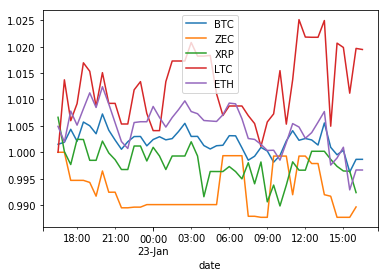

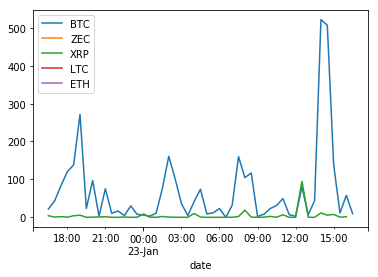

In [66]:
df3 = pd.DataFrame()
df4 = pd.DataFrame()
for c in coinlist:
    df3[c] = df2.loc[c]['volume'].div(first_volume[c], axis=0)
for c in coinlist:
    df4[c] = df2.loc[c]['close'].div(first_open_prices[c], axis=0)
df4.plot(None, coinlist)
df3.plot(None, coinlist)
plt.show()

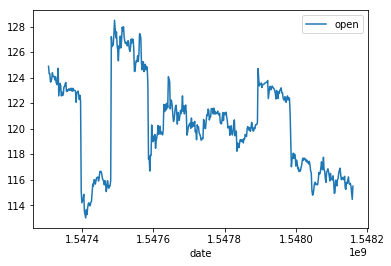

In [153]:
df.loc['ETH'].plot(x=None, y='open')

In [48]:
df2 = df.copy()
df2 =df2.set_index(['date', 'coin'])
df2.head()

,,close,high,low,open,quoteVolume,volume,weightedAverage
date,coin,,,,,,,
1548259500,BTC,3563.597220,3563.897231,3557.348315,3557.348315,4.109292,14642.900681,3563.363722
1548259800,BTC,3563.235156,3563.243715,3563.235156,3563.243715,0.811403,2891.227037,3563.243502
1548260100,BTC,3562.935150,3562.935150,3562.935150,3562.935150,0.001587,5.654378,3562.935150
1548260400,BTC,3561.546998,3562.535140,3560.955953,3562.535140,0.091464,325.839611,3562.475094
1548260700,BTC,3561.911980,3561.911980,3561.911980,3561.911980,0.003535,12.590468,3561.911980


In [43]:
from gbportfolio.data.data import GlobalData
from gbportfolio.data.poloniex import Poloniex
import json

class LocalData(GlobalData):
    """
    This class is used for storing very short ticks (should be 5M or 15M) in ram instead in DB.
    Used for playing with recent data (horizon < 1W)
    """
    def __init__(self, start, end, period, base_currency, coinlist):
        assert period in [300, 900]
        self.db = pd.DataFrame()
        self.start = start
        self.end = end
        self.period = period
        self.base_currency = base_currency
        self.coinlist = coinlist
        
    def fill_db(self):
        polo = Poloniex()
        for c in self.coinlist:
            pair = self.base_currency + "_" + c
            try:
                db = pd.DataFrame(self._get_chart_until_success(polo, pair, self.start, self.period, self.end))
                db['coin'] = c
                self.db = pd.concat([self.db, db])
            except Exception as e:
                print(e)
        
                
    def get_db(self):
        return self.db
        

In [228]:
#['BTC', 'ETH', 'LTC', 'XRP', 'ZEC', 'XMR', 'STR', 'ETC', 'DASH', 'EOS']
ld = LocalData(time.time()-12*24*60*60,time.time(),900,'USDT', ['BTC', 'ETH', 'LTC', 'ZEC', 'DASH'])
ld.fill_db()
df = ld.get_db()
df =df.set_index(['coin', 'date'])
#convert index to datetime
df.index = df.index.set_levels([df.index.levels[0], pd.to_datetime(df.index.levels[1], unit='s')])
df = df.sort_index()
coinlist = list(set(df.index.get_level_values(0)))
#print("g", coinlist)
#get the time of last open price for each index
last_open_times = {c : df.loc[c].index.max() for c in coinlist}
last_open_prices = {c : df.loc[(c, last_open_times[c])]['open'] for c in coinlist}
first_open_times = {c : df.loc[c].index.min() for c in coinlist}
first_open_prices = {c : df.loc[(c, first_open_times[c])]['open'] for c in coinlist}
first_volume = {c : df.loc[(c, first_open_times[c]):(
                c, first_open_times[c]+dt.timedelta(
                seconds=24*60*60))]['volume'].mean() for c in coinlist}
total_first_volume = 0
counter = 0
for v in first_volume.values():
    total_first_volume += v
    counter += 1
print(counter, total_first_volume)
mean_total_volume = total_first_volume/counter
print(mean_total_volume)

5 20800.046141392988
4160.009228278597


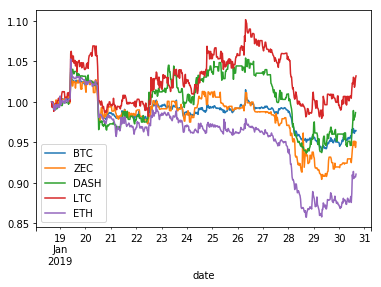

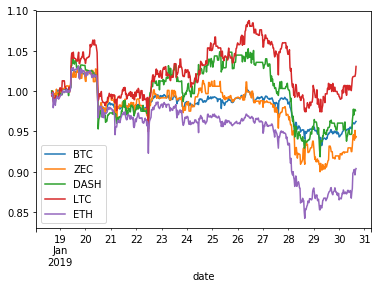

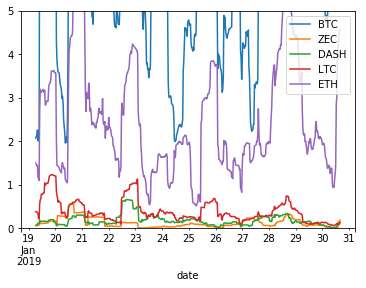

In [229]:
    df2 = pd.DataFrame()

    df2['high'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).max()['high']
    df2['low'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).min()['low']
    df2['open'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).first()['open']
    df2['close'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).last()['close']
    df2['volume'] = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq=fr, level=-1)]).sum()['volume']

    df3 = pd.DataFrame()
    df4 = pd.DataFrame()
    df5 = pd.DataFrame()
    for c in coinlist:
        df3[c] = df2.loc[c]['high'].div(first_open_prices[c], axis=0)
    for c in coinlist:
        df4[c] = df2.loc[c]['low'].div(first_open_prices[c], axis=0)
    for c in coinlist:
        df5[c] = df2.loc[c]['volume'].div(mean_total_volume, axis=0)
        df5[c] = df5[c].rolling(30).mean()
    df3.plot(None, coinlist)
    df4.plot(None, coinlist)
    vol_plot = df5.plot(None, coinlist)
    vol_plot.set_ylim(0,5 )
    plt.show()


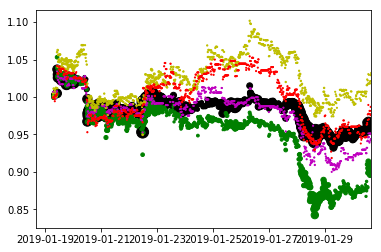

In [230]:
data = {'BTC':'k', 'ETH':'g', 'ZEC':'m', 'LTC':'y', 'DASH':'r'}
for c in data.keys():
    plt.scatter(df3.index, df3[c], s=(df5[c]+1)**2, c=data[c])
    plt.scatter(df3.index, df4[c], s=(df5[c]+1)**2, c=data[c])
first_key = list(data.keys())[0]
plt.xlim(first_open_times[first_key], last_open_times[first_key])
plt.show()

In [153]:
import plotly


ModuleNotFoundError: No module named 'plotly'